# Open-loop planning with straightline plans in JaxPlan.

This rudimentary example illustrates how to set up an offline JaxPlan agent that first optimizes the problem and then evaluates.

First install and import the required packages:

In [1]:
%pip install --quiet --upgrade pip
%pip install --quiet git+https://github.com/pyrddlgym-project/pyRDDLGym.git
%pip install --quiet git+https://github.com/pyrddlgym-project/rddlrepository.git
%pip install --quiet git+https://github.com/pyrddlgym-project/pyRDDLGym-jax.git

Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.
Note: you may need to restart the kernel to use updated packages.


Import the required packages:

In [2]:
import warnings
warnings.filterwarnings("ignore", category=UserWarning)
import os
from IPython.display import Image

import pyRDDLGym
from pyRDDLGym.core.visualizer.movie import MovieGenerator
from pyRDDLGym_jax.core.planner import JaxStraightLinePlan, JaxBackpropPlanner, JaxOfflineController, load_config_from_string

We will optimize the reacher multi-jointed arm control problem. Please note that the environment state and action fluents should be vectorized tensors for JaxPlan, so we **must enable the ``vectorized`` option**:

In [3]:
env = pyRDDLGym.make('Reacher_gym', '0', vectorized=True)

Now we will construct a straight-line offline planner as our policy, using the default parameters. This instantiates an independent trainable parameter vector for each action-fluent per decision time step. Note that the controller is an instance of the pyRDDLGym ``BasePolicy``, so it will support normal interaction with pyRDDLGym environments out of the box:

In [4]:
planner = JaxBackpropPlanner(rddl=env.model, plan=JaxStraightLinePlan())
agent = JaxOfflineController(planner, print_summary=False, train_seconds=20)
agent.evaluate(env, episodes=1)

   4708 it /    -180.823074 train /    -197.369858 test /    -165.300537 best / 5 status: : 4708it [00:19, 236.05it/s]                                 


{'mean': np.float64(-165.30028666288638),
 'median': np.float64(-165.30028666288638),
 'min': np.float64(-165.30028666288638),
 'max': np.float64(-165.30028666288638),
 'std': np.float64(0.0)}

We can do better! Since JaxPlan can be sensitive to hyper-parameter choices, Let's repeat the previous exercise but with tweaked hyper-parameters. Specifically, let's decrease the learning rate, change the optimizer to ADAM, and remove mini-batching since this environment is deterministic. This is much easier to provide in a configuration file as follows:

In [5]:
config = """
[Model]
[Optimizer]
method='JaxStraightLinePlan'
optimizer='adam'
optimizer_kwargs={'learning_rate': 0.0001}
batch_size_train=1
batch_size_test=1
[Training]
key=42
"""
planner_args, _, train_args = load_config_from_string(config)

In [6]:
planner = JaxBackpropPlanner(rddl=env.model, **planner_args)
agent = JaxOfflineController(planner, print_summary=False, train_seconds=20, **train_args)
agent.evaluate(env, episodes=1)

   7720 it /      -7.962150 train /      -7.963146 test /      -7.963146 best / 5 status: : 7720it [00:20, 375.66it/s]                                 


{'mean': np.float64(-7.961858548418148),
 'median': np.float64(-7.961858548418148),
 'min': np.float64(-7.961858548418148),
 'max': np.float64(-7.961858548418148),
 'std': np.float64(0.0)}

Let's visualize our trained agent's behavior:

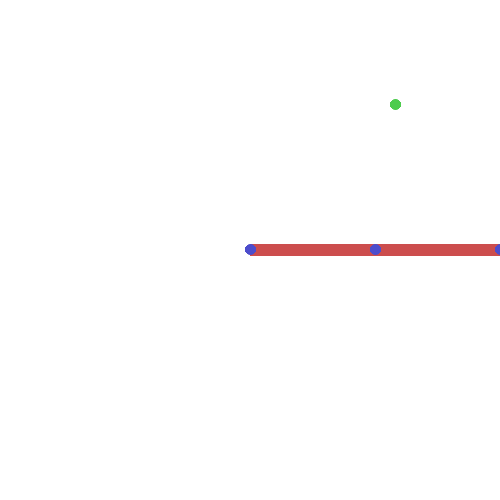

In [7]:
if not os.path.exists('frames'):
    os.makedirs('frames')
recorder = MovieGenerator("frames", "reacher", max_frames=env.horizon)
env.set_visualizer(viz=None, movie_gen=recorder)
agent.evaluate(env, episodes=1, render=True)
env.close()
Image(filename='frames/reacher_0.gif') 